# Rap Lyrics Generator - Kanye West

## Introduction
This project uses 300+ Kanye West's verses to train on Recurrent Nural Network (RNN). The verses file is [from a dataset on Kaggle](https://www.kaggle.com/viccalexander/kanyewestverses). The dataset contains total of 364 verses from 243 songs. Each verses are seprated by an empty line which consist of "\n". This project is trained on characters based features. i.e. the embeding step is based on characters, not words.
This project is inspried by a NLP course on coursera in Tensorflow in practice specitialization offer by deeplearning.ai and [Tensorflow tutorial](https://www.tensorflow.org/tutorials/text/text_generation). The process is to prepare the lyrics and window them into segments the use the characters in these windows to predict the next character. Since each character is related to its previous and next character, RNN and LSTM that carry hidden state from previous cell are suitable for this application. 

### Import Packages

In [1]:
import numpy as np 
import tensorflow as tf

print(tf.__version__)
#!pip install tensorflow==2.0.0

2.0.0


### load the file print the first 250 characters

In [2]:
# Read, then decode for py2 compat.
text = open('kanye_verses.txt', 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it

print ('Length of text: {} characters'.format(len(text)))
print(text[:250])

Length of text: 260341 characters
Let the suicide doors up
I threw suicides on the tour bus
I threw suicides on the private jet
You know what that mean, I'm fly to death
I step in Def Jam buildin' like I'm the shit
Tell 'em give me fifty million or I'ma quit
Most rappers' taste level


### Unique character
We are using character based feature, so we want to identify the total number of unique charactor and give each one of them a numerical label.

In [3]:
# number of unique characters 
print(len(set(text)),'unique characters:') 

# dict of these characters
chars = sorted(set(text))
print(chars)

char_dict = {char:i for i,char in enumerate(chars)}
idx2char = np.array(chars)
print(char_dict)

96 unique characters:
['\n', ' ', '!', '"', '#', '$', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '·', 'Á', 'é', 'í', 'ñ', 'ó', 'ā', '\u200b', '–', '‘', '’', '“', '”', '…']
{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '&': 6, "'": 7, '(': 8, ')': 9, '*': 10, '+': 11, ',': 12, '-': 13, '.': 14, '/': 15, '0': 16, '1': 17, '2': 18, '3': 19, '4': 20, '5': 21, '6': 22, '7': 23, '8': 24, '9': 25, ':': 26, ';': 27, '?': 28, 'A': 29, 'B': 30, 'C': 31, 'D': 32, 'E': 33, 'F': 34, 'G': 35, 'H': 36, 'I': 37, 'J': 38, 'K': 39, 'L': 40, 'M': 41, 'N': 42, 'O': 43, 'P': 44, 'Q': 45, 'R': 46, 'S': 47, 'T': 48, 'U': 49, 'V': 50, 'W': 51, 'X': 52, 'Y': 53, 'Z': 54, 'a':

### Transform lyrics to numerical labels
Here each characters are transform to relative numerical label that I created above so they can be then feed into Tensorflow.

In [4]:
#Sequence of the text
text_in_num =np.array([char_dict[i] for i in text])
print(text[:13])
print(text_in_num[:13])

print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_in_num[:13]))


Let the suici
[40 59 74  1 74 62 59  1 73 75 63 57 63]
'Let the suici' ---- characters mapped to int ---- > [40 59 74  1 74 62 59  1 73 75 63 57 63]


### Create sequences for training X and Y
In order to create X (feature set) and Y, the answer,(ground truth), the entire lyrics file are flaten to a single vactor(1,# of chars). The sequences (training samples) are extracted by shifting a window down to the vector. For example, If the lyrics file in a single vector is : \[0,1,2,3,4,5,6,7,8,9\]. We use a window size of 3 and shift every 1 character, we will get:\[0,1,2\] \[1,2,3\] \[2,3,4\] \[3,4,5\] \[4,5,6\] \[5,6,7\] \[6,7,8\] and \[7,8,9\].

The window size is defined by the length of each sequence(training sample). The sample is the first character to n-1 th. The second to the last characters are our target, Y. i.e. an instance is \[0,1,2,3\]: Training sequence :\[0,1,2\], target:\[1,2,3\]

In [5]:
#Convert to trainable data
seq_len = 50
example_per_epoc = (len(text_in_num)-seq_len)//5
BATCH_SIZE = 64
example_per_epoc


52058

In [6]:
# Create training examples / targets

#Make the data in numerical lable to Tf.dataset for furter processing
char_dataset = tf.data.Dataset.from_tensor_slices(text_in_num)

#Creating sequences 
sequences = char_dataset.window(size = seq_len+1, shift = 10, drop_remainder = True)

#Get training instance (training sequence + Target) and Flaten out the entire dataset 
sequences = sequences.flat_map(lambda window: window.batch(seq_len+1))

#Creating tuple for each train instance : (sequence, target)
dataset = sequences.map(lambda window: (window[:-1], window[1:]))

BUFFER_SIZE = 1000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)


for i,y in dataset.take(1):
    print('Sample:(batch_size, sequence_len)')
    print(i.numpy().shape)
    print('Target:(batch_size,)')
    print(y.numpy().shape)
    
#Sample:(batch_size, sequence_len)
#(64, 50)
#Target:(batch_size,)
#(64, 50)
#

Sample:(batch_size, sequence_len)
(64, 50)
Target:(batch_size,)
(64, 50)


### Print out the first 10 sequences with window size 50 and shift = 5

In [7]:
for batch,batch_target in  dataset.take(1):
    for i in range(10):
        print ('Input data: ', repr(''.join(idx2char[batch[i].numpy()])))
    

Input data:  "le get money, don't spend it\nOr maybe they get mon"
Input data:  'ld you\nBefore the blood on the leaves\nI know there'
Input data:  "e long-ass verses\nI'm tired, you tired, Jesus wept"
Input data:  'nly felony\nSo never fuck nobody without telling me'
Input data:  'itchAlert\nHe Instagram his watch like #MadRichAler'
Input data:  'o you bring home\nThey see a black man with a white'
Input data:  'out the girl in all leopard\nWho was rubbing the wo'
Input data:  "n one day\nEverytime I'm in Vegas they screaming li"
Input data:  'ething out me\nThen they talk about me\nWould be los'
Input data:  'ival - the un-American idols\nWhat niggas did in Pa'


### The first 5 sequences and respective targets

In [8]:
for batch,batch_target in  dataset.take(1):
    for i in range(5):
        print ('Input data: ', repr(''.join(idx2char[batch[i].numpy()])))
        print ('Target data:', repr(''.join(idx2char[batch_target[i].numpy()])))

Input data:  "I'd be worried if they said nothing\nRemind me wher"
Target data: "'d be worried if they said nothing\nRemind me where"
Input data:  "st step\nAnd hey, you know ain't nobody perfect\nAnd"
Target data: "t step\nAnd hey, you know ain't nobody perfect\nAnd "
Input data:  'that alimony, uh, yeah-yeah, she got you homie, ye'
Target data: 'hat alimony, uh, yeah-yeah, she got you homie, yea'
Input data:  "now\nIt's been racin' since the summertime\nNow I'm "
Target data: "ow\nIt's been racin' since the summertime\nNow I'm h"
Input data:  'rst molly\nAnd came out of your body\nAnd came out o'
Target data: 'st molly\nAnd came out of your body\nAnd came out of'


### Build the model
The model consists of an embeding layer, a RNN (GRU) layer, and a dense output layer. As the "return_sequence" is set to True, the output of GRU layer is output the state of each call in the GRU. The dense lyaer outputs the probability of each charater for each state. 

In [57]:
# Length of the vocabulary in chars
vocab_size = len(chars)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 128

In [74]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    # Emdedding layer    
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),  
    # RNN layer    
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
        
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True),
    # Dense layer    
    tf.keras.layers.Dense(vocab_size)
      ])
    return model

model = build_model(
  vocab_size = len(chars),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

### Take a look what each batch looks like:

In [39]:
for input_example_batch, target_example_batch in dataset.take(1):
    print(input_example_batch)
    print(target_example_batch)

tf.Tensor(
[[37 74  7 ...  1 56 55]
 [59  1 73 ... 37  1 73]
 [61 63 72 ... 70 75 74]
 ...
 [73  1 67 ...  1 56 69]
 [77 68  1 ... 74  1 56]
 [60 74 79 ... 76 59 66]], shape=(64, 50), dtype=int32)
tf.Tensor(
[[74  7 73 ... 56 55 57]
 [ 1 73 55 ...  1 73 55]
 [63 72 66 ... 75 74 55]
 ...
 [ 1 67 59 ... 56 69 58]
 [68  1 74 ...  1 56 75]
 [74 79  1 ... 59 66  1]], shape=(64, 50), dtype=int32)


In [12]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 50, 96) # (batch_size, sequence_length, vocab_size)


As seen above, each batch contains 64 samples, each sample has input and target which both constins 50 charaters. 


### Model summary:

In [75]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (64, None, 256)           24576     
_________________________________________________________________
gru_7 (GRU)                  (64, None, 128)           148224    
_________________________________________________________________
lstm_5 (LSTM)                (64, None, 128)           131584    
_________________________________________________________________
dense_7 (Dense)              (64, None, 96)            12384     
Total params: 316,768
Trainable params: 316,768
Non-trainable params: 0
_________________________________________________________________


### Sample indices
Input random lyrics and use untrained model to predict the lyrics

In [14]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [15]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 "me\nWe could've been somebody\nThought you'd be diff"

Next Char Predictions: 
 '\'”tFDpmMj",9-·A7é5dUnJO8(O4r1Xa:A6*“zELC9 r2F’8U??'


### Define loss function and compile the model
Catergorical crossentropy

In [76]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 50, 96)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.56478


In [77]:
model.compile(optimizer='adam', loss=loss)

### Train the model
Here define a callback to save checkpoint for each epoch so that we can refer to the weight at each epoch at later step.


In [78]:
import os
import time

In [79]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "c_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [80]:
EPOCHS=10

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10


W1209 05:37:12.945901  1292 util.py:144] Unresolved object in checkpoint: (root).optimizer
W1209 05:37:12.950873  1292 util.py:144] Unresolved object in checkpoint: (root).optimizer.iter
W1209 05:37:12.954874  1292 util.py:144] Unresolved object in checkpoint: (root).optimizer.beta_1
W1209 05:37:12.957867  1292 util.py:144] Unresolved object in checkpoint: (root).optimizer.beta_2
W1209 05:37:12.960873  1292 util.py:144] Unresolved object in checkpoint: (root).optimizer.decay
W1209 05:37:12.962870  1292 util.py:144] Unresolved object in checkpoint: (root).optimizer.learning_rate
W1209 05:37:12.967863  1292 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings
W1209 05:37:12.972859  1292 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.kernel
W1209 05:37:12.974859  1292 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_we

406/406 [==============================] - 331s 816ms/step - loss: 2.6772
Epoch 2/10
406/406 [==============================] - 385s 948ms/step - loss: 2.0154
Epoch 3/10
406/406 [==============================] - 425s 1s/step - loss: 1.8261
Epoch 4/10
406/406 [==============================] - 293s 723ms/step - loss: 1.7327
Epoch 5/10
406/406 [==============================] - 380s 936ms/step - loss: 1.6738
Epoch 6/10
406/406 [==============================] - 373s 919ms/step - loss: 1.6311
Epoch 7/10
406/406 [==============================] - 380s 936ms/step - loss: 1.5968
Epoch 8/10
271/406 [===================>..........] - ETA: 1:45 - loss: 1.5672

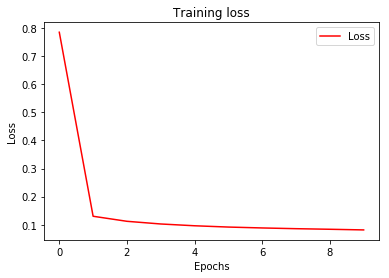

In [66]:
import matplotlib.pyplot as plt
loss=history.history['loss']
epochs=range(len(loss)) # Get number of epochs
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.show()

### Creat a new model use trained weight

Looking at the loss for each epoc, seems the 18th epoc works pretty good.

In [67]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints\\c_10'

In [68]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
#model.load_weights('./training_checkpoints\\c_18')
model.build(tf.TensorShape([1, None]))

In [69]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (1, None, 256)            24576     
_________________________________________________________________
bidirectional_3 (Bidirection (1, None, 256)            296448    
_________________________________________________________________
dense_6 (Dense)              (1, None, 96)             24672     
Total params: 345,696
Trainable params: 345,696
Non-trainable params: 0
_________________________________________________________________


### Lyrics Generator
Finally define the lyrics generator function that feed in a string and predict the next character.

In [72]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
    num_generate = 300

  # Converting our start string to numbers (vectorizing)
    input_eval = [char_dict[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
    text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
    temperature = 0.8

  # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
      # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)
        #print(predictions)

      # using a categorical distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        #print(tf.random.categorical(predictions, num_samples=1))
      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)
        
        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

### Prediction

It is around Thanksgiving, let's try use "Thanksgiving" as start string and see what we will get:

In [73]:
print(generate_text(model, start_string="Thanksgiving"))

Thanksgiving
Thinininininininininininininininininininininininininininininininininininininininininininininininsns s s s s m memememememememememe evevevevevevevevevevevevevevevevevevevevevevevevevevevevevenenenenenenenenenenenererererererererererererererererererererererererererererererer r l Wexexexexexexexexexex


## Conclusion

Here I generated 1000 characters for given start string "Thanksgiving". Since the chance of line "\n" and space are also been part of the training vocab, the auto-generated lyrics will switch lines between bars and skip a line between verses. Not looking at the contex, this lyrics looks somehow legit. Some intresting found after deep inspecting the lyrics:

- The vocab is case senetive, so it's good to see the model generate the lyrics that captalize the first character of each line also some names like "Coldplay". 

- It also know to use quotation marks after the word "say", for example, They say Drive Slow, I say "I know".

- Also, we can see the lyric is impacted by Kanye. For example, he is known as a Christian rapper. We can see some lyrics that are God related:
    May the Lord forgive us, me it was this is Christians

- Even rhyme can be seen sometime:

Overall, the auto-generated lyrics of course is not as good as the original ones. However, it presents the ability of NLP and an possible way to generate text of different content. This model is trained using charater based RNN due to it has less unique "labels" so can largly reduce the computational expense. The drawback is the composition of sentances and verses may not make much sence to people. The model can be improved by using "word-based" vocab and input more samples and train.


# Happy Thanksgiving!
    
    


